Key Points:

To be plotted a (multi)polygon must be in form: geopandas.geodataframe.GeoDataFrame

To run 'intersects' it must be a str representing a geojson geometry

To display on leaflet map must be a dict representing a geojson geometry

To use as mask for xarray 'clip it must be a list (of coordinates)

In [98]:
#!pip install rioxarray
import dask.array as da
from pystac_client import Client
import leafmap
from datetime import datetime
import dask
import pystac_client
import planetary_computer as pc
import leafmap
import geogif
import numpy as np
import xarray as xr
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
import geojson
import json
import shapely
from geogif import dgif, gif
import pandas as pd

In [2]:
# stackstac needs to be 0.5.0
# if it is not run "conda install -c conda-forge stackstac" in MPC terminal and then restart this kernal
# or maybe this works? !pip install --upgrade stackstac==0.5.0 
import stackstac
stackstac.__version__

'0.5.0'

In [3]:
# Start by reading in shapefiles of veg class
# In this case it is a feature class of every patch of eucalyptus within a fire perimeter that's burned since 2002
EucList= gpd.read_file("Euc/EucInFires.shp")
# Filter to only vegetation patches > 5 acres
EucList= EucList[EucList['Acres']>5]

In [4]:
# Read in Fire shapefiles with veg class erased
FireList= gpd.read_file("Fires/FiresWithEucSince2002.shp")
# Select observations in 'FireList' where 'FIRE_NAME' is in 'EucList'
FireList = FireList[FireList['FIRE_NAME'].isin(EucList['FIRE_NAME'])]
#FireList

In [5]:
# We notice that there are two seperate items named "Lakeville" in FiresList
# We will dissolve these into one
Fires_dissolved = FireList.dissolve(by='FIRE_NAME')
print(len(Fires_dissolved))
print(len(EucList))

13
13


In [6]:
# Notice that the dissolve function orders and indexes the items by "FIRE_NAME" (alphabetically)
Fires_dissolved

,geometry,YEAR_,STATE,AGENCY,UNIT_ID,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,COMPLEX_NA,COMPLEX_IN,IRWINID,Shape_Leng,Shape_Area
FIRE_NAME,,,,,,,,,,,,,,,,,,,
37,"MULTIPOLYGON (((-13632509.137 4598957.010, -13...",2017,CA,CDF,LNU,00002957,2017-10-09,2017-10-16,11,LFB8. DIGITIZED FROM DIGITALGLOBE (MAXAR) IMA...,1613.2200,4,1,None,None,None,F570C977-2D96-4BB0-A146-52D1A32FA87D,46336.050945,1.057459e+07
CZU LIGHTNING COMPLEX,"MULTIPOLYGON (((-13597620.755 4446934.894, -13...",2020,CA,CDF,CZU,00005205,2020-08-16,2020-09-24,1,None,86553.5000,7,1,None,CZU LIGHTNING COMPLEX,00005205,None,255052.193260,5.523185e+08
FREEDOM,"MULTIPOLYGON (((-13563048.689 4435546.887, -13...",2021,CA,CDF,CZU,00000489,2021-01-19,2021-01-22,11,None,33.2592,1,1,None,None,None,None,4130.554410,2.112959e+05
GLASS,"MULTIPOLYGON (((-13643876.651 4640554.214, -13...",2020,CA,CDF,LNU,00015497,2020-09-27,2020-10-20,14,J. Baldwin,67484.4000,7,1,None,None,None,None,272074.173454,4.470432e+08
HIGHWAY,"POLYGON ((-13596880.850 4581607.603, -13596854...",2004,CA,CDF,SCU,00003485,2004-06-25,2004-06-28,2,None,624.9360,1,1,00000181,None,None,None,10317.778914,4.080267e+06
KINCADE,"MULTIPOLYGON (((-13671601.809 4659663.511, -13...",2019,CA,CDF,LNU,00019376,2019-10-23,2019-11-10,11,None,77762.1000,1,1,None,None,None,None,238568.856409,5.171126e+08
LAKEVILLE,"MULTIPOLYGON (((-13639543.184 4606214.242, -13...",2020,CA,CDF,LNU,00008347,2020-06-05,2020-06-05,2,Brandon Bertolino,159.6800,6,1,None,None,None,None,4456.877916,1.048804e+06
NUNS,"POLYGON ((-13645735.366 4645908.991, -13645731...",2017,CA,CDF,LNU,00010049,2017-10-08,2017-10-31,14,"Nuns,Partrick, Adobe, Norrbom and Pressley mer...",55798.2000,3,1,None,SOUTHERN LNU COMPLEX,00010105,None,305483.095957,3.680012e+08
PRESSLEY,"POLYGON ((-13650997.823 4632998.507, -13650986...",2017,CA,CDF,LNU,00010049,2017-10-08,2017-10-15,14,Merged into Nuns,791.8880,7,1,None,SOUTHERN LNU COMPLEX,00010105,None,22361.236288,5.220480e+06


In [7]:
# We need to do the same sorting and indexing with EucList
EucList_sorted = EucList.sort_values(by='FIRE_NAME')
Euc_set = EucList_sorted.set_index('FIRE_NAME')

In [8]:
# Change everything to 4326 and verify geometry is not in coordinates
EucAreas = Euc_set.to_crs(4326)
Fires_4326 = Fires_dissolved.to_crs(4326)
#FireAreas

In [66]:
# Difference Eucs from Fire areas
# Subtract vegetation_union from all fire perimeters in 'FireList'
Fires_diff = Fires_4326['geometry'].difference(EucAreas['geometry'])

# Take geometries from FireList_diff and use it as geometry in FireList_sorted, to retain other attributes
FireAreas = Fires_4326.set_geometry(Fires_diff)

#temp_geo = modified_firelist.head(1).values[0]
#Fires_diff.iloc[1].plot()
type(FireAreas)

geopandas.geodataframe.GeoDataFrame

In [68]:
FireAreas.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
# You could plot all the fires areas
#ax = FireAreas.plot(color='red', alpha=0.5, label='Fire Area')

# Add legend
#ax.legend()

# Show the plot
#plt.show()

In [11]:
# Make sure FireAreas and EucAreas match up
# Pulling out an individual fire and matching Euc
# However doing so changes the datatype to shapely polygon
# Turn it back into a pandas geodataframe in order to be plotted

fire_example = FireAreas.iloc[0].geometry
euc_example = EucAreas.iloc[0].geometry

# Create GeoDataFrames with a single row for visualization
gdf_fire_example = gpd.GeoDataFrame(geometry=[fire_example])
gdf_euc_example = gpd.GeoDataFrame(geometry=[euc_example])
type(fire_example)

shapely.geometry.multipolygon.MultiPolygon

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


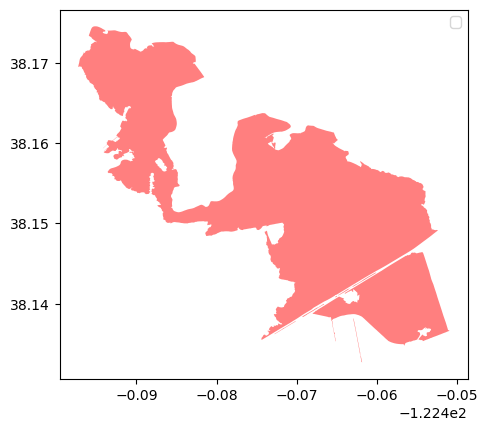

In [12]:
# First plot the fire area
ax = gdf_fire_example.plot(color='red', alpha=0.5, label='Fire Area')

# Add legend
ax.legend()

# Show the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


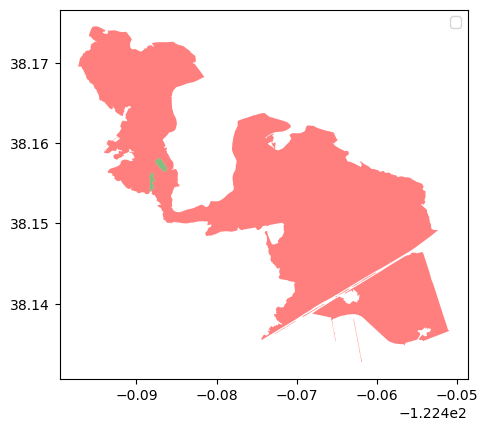

In [13]:
# Plot the Eucalyptus areas on the same plot
# First plot the fire area
ax = gdf_fire_example.plot(color='red', alpha=0.5, label='Fire Area')
gdf_euc_example.plot(ax=ax, color='green', alpha=0.5, label='Eucalyptus Area')

# Add legend
ax.legend()

# Show the plot
plt.show()


In [14]:
print(gdf_fire_example)
print(gdf_euc_example)

                                            geometry
0  MULTIPOLYGON Z (((-122.46290 38.13806 0.00000,...
                                            geometry
0  MULTIPOLYGON Z (((-122.48783 38.15605 0.00000,...


In [15]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jaandrews@clarku.edu/proxy/8787/status,
Dashboard: /user/jaandrews@clarku.edu/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38867,Workers: 4
Dashboard: /user/jaandrews@clarku.edu/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:45019,Total threads: 1
Dashboard: /user/jaandrews@clarku.edu/proxy/42879/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:40945,


In [16]:
api_url = "https://planetarycomputer.microsoft.com/api/stac/v1"


In [17]:
start_date = datetime(2002, 1, 1).isoformat()
end_date = datetime(2023, 12, 31).isoformat()
bbox = (-123.74286820900588, 36.79177481727697, -121.16108109963088, 38.82267288995824)


In [20]:
#Ideally we would clip to the study area exactly, rather than including pointless pictures of the ocean that would be included with bbbox
counties= gpd.read_file("Counties/counties.shp")
#counties.head()
#counties.plot()
type(counties)

geopandas.geodataframe.GeoDataFrame

In [21]:
#However there are several steps necessary to get "counties" into the right format for the stacstack 'intersects' function
# The shapefile is in meters intstead of coordinates, so we have to start by giving it a crs
counties_4326 = counties.to_crs(4326)
# If it was a simpler shape, with fewer points you could feed counties_4326 into a geojson now. But it needs to be a smaller file
# so we'll start by dissolving the individual counties into one geometry
counties_combined = counties_4326.unary_union
# and getting the convex hull
counties_convex = counties_combined.convex_hull
# convert this back into a geopandas geodataframe
convex_df = gpd.GeoDataFrame(geometry=[counties_convex])
convex_df.set_crs(4326)
# Turn it back ito a geojson
convex_json = convex_df.to_json()
# However it is a feature collection, but needs to be a (multi-) point, line, or feature
convex_json
# so we will extract the geometry
geometry_part = json.loads(convex_json)["features"][0]["geometry"]
# Create a GeoJSON string (representing a polygon) with the geometry part
geometry_geojson = json.dumps(geometry_part)
# finally this can be used by the intersect function

In [22]:
SA= geometry_geojson

In [23]:
catalog = pystac_client.Client.open(api_url)

search = catalog.search(
    datetime=f"{start_date}/{end_date}",
    collections=["landsat-c2-l2"],
    intersects=SA,
    #bbox=bbox,
    query=["eo:cloud_cover<2"],
    max_items=2000
)


In [24]:
%%time
items = pc.sign(search)
len(items)

CPU times: user 4.89 s, sys: 448 ms, total: 5.34 s
Wall time: 15.2 s


1366

In [25]:
# Display the study area
# This takes a while to run and is not really necessary
m = leafmap.Map(center=[37.82, -122.39], zoom=10, height="800px")
# To visualize study area we have to use version that is a geo_json dict
m.add_geojson(geometry_part, colors = "red", layer_name = 'Study Area')
# and all the swaths that intersect it
m.add_geojson(items.to_dict())
m

string indices must be integers, not 'str'


Map(center=[37.82, -122.39], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [26]:
# What about visualizing the differenced fires on leafmap?
#FireAreas
print(type(FireAreas))
#print(FireAreas)

<class 'geopandas.geodataframe.GeoDataFrame'>
                                                                geometry  \
FIRE_NAME                                                                  
37                     MULTIPOLYGON Z (((-122.46290 38.13806 0.00000,...   
CZU LIGHTNING COMPLEX  MULTIPOLYGON Z (((-122.14943 37.05604 0.00000,...   
FREEDOM                MULTIPOLYGON Z (((-121.83891 36.97447 0.00000,...   
GLASS                  MULTIPOLYGON Z (((-122.56526 38.43137 0.00000,...   
HIGHWAY                POLYGON Z ((-122.14262 38.01536 0.00000, -122....   
KINCADE                MULTIPOLYGON Z (((-122.81407 38.56608 0.00000,...   
LAKEVILLE              MULTIPOLYGON Z (((-122.52663 38.18976 0.00000,...   
NUNS                   MULTIPOLYGON Z (((-122.58169 38.46910 0.00000,...   
PRESSLEY               POLYGON Z ((-122.62889 38.37732 0.00000, -122....   
SCENIC                 MULTIPOLYGON Z (((-122.19706 38.05275 0.00000,...   
TAM                    MULTIPOLYGON Z (((-

In [27]:
# Fancy bit of code right here

from shapely.geometry import mapping

# Assuming you already have your FireAreas GeoDataFrame
# Create a Leaflet Map
m1 = leafmap.Map(center=[37.82, -122.39], zoom=9, height="800px")

# Iterate over the rows of the GeoDataFrame
for index, row in FireAreas.iterrows():
    # Convert the geometry to a GeoJSON-like dictionary
    feature_geometry = mapping(row.geometry)
    
    # Add the GeoJSON-like dictionary to the map
    m1.add_geojson(feature_geometry, layer_name=f"Fire {index}")

# Display the map
m1


string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'


Map(center=[37.82, -122.39], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [83]:
# We could also just map an individual fire
from shapely.geometry import mapping

# Assuming you already have your FireAreas GeoDataFrame
fire_example = FireAreas.iloc[2].geometry

# Convert the geometry directly to a GeoJSON dictionary
example_geometry = mapping(fire_example)

# Create a Leaflet Map
m1 = leafmap.Map(center=[36.981601, -121.837663], zoom=14, height="800px")

# Add the GeoJSON dictionary to the map
m1.add_geojson(example_geometry, layer_name="Sample Fire")

# Display the map
m1


string indices must be integers, not 'str'


Map(center=[36.981601, -121.837663], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [28]:
# Initialize image stack
#
%time
stack = stackstac.stack(items, bounds_latlon=bbox)
stack


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


<xarray.DataArray 'stackstac-f5d939d32a40dff483caac8d004d941f' (time: 1366,
                                                                band: 22,
                                                                y: 7557, x: 7679)>
dask.array<fetch_raster_window, shape=(1366, 22, 7557, 7679), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/31)
  * time                         (time) datetime64[ns] 2002-02-28T18:40:49.42...
    id                           (time) <U31 'LE07_L2SP_045033_20020228_02_T1...
  * band                         (band) <U13 'qa' 'red' ... 'qa_aerosol'
  * x                            (x) float64 4.337e+05 4.337e+05 ... 6.64e+05
  * y                            (y) float64 4.299e+06 4.299e+06 ... 4.072e+06
    platform                     (time) <U9 'landsat-7' ... 'landsat-8'
    ...                           ...
    raster:bands                 (band) object {'unit': 'kelvin', 'scale': 0....
    classification:bitfields     (band) object None ... [{'name': 'fill', 'le...
    common_name                  (band) object None None None ... 'coastal' None
    center_wavelength            (band) object None None None ... 10.9 0.44 None
    full_width_half_max          (band) object None None None ... 0.59 0.02 None
    epsg                         int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(433710.0, 4072020.0, 664080.0...
    crs:         epsg:32610
    transform:   | 30.00, 0.00, 433710.00|\n| 0.00,-30.00, 4298730.00|\n| 0.0...
    resolution:  30.0

In [29]:
# Band names are not trivial from the initial query
stack.band


<xarray.DataArray 'band' (band: 22)>
array(['qa', 'red', 'blue', 'drad', 'emis', 'emsd', 'lwir', 'trad', 'urad',
       'atran', 'cdist', 'green', 'nir08', 'swir16', 'swir22', 'cloud_qa',
       'qa_pixel', 'qa_radsat', 'atmos_opacity', 'lwir11', 'coastal',
       'qa_aerosol'], dtype='<U13')
Coordinates: (12/15)
  * band                       (band) <U13 'qa' 'red' ... 'coastal' 'qa_aerosol'
    description                (band) object 'Collection 2 Level-2 Quality As...
    landsat:correction         <U4 'L2SP'
    landsat:wrs_type           <U1 '2'
    gsd                        (band) object None None None ... 100 None None
    landsat:collection_number  <U2 '02'
    ...                         ...
    raster:bands               (band) object {'unit': 'kelvin', 'scale': 0.01...
    classification:bitfields   (band) object None ... [{'name': 'fill', 'leng...
    common_name                (band) object None None None ... 'coastal' None
    center_wavelength          (band) object None None None ... 10.9 0.44 None
    full_width_half_max        (band) object None None None ... 0.59 0.02 None
    epsg                       int64 32610

In [30]:
stack.sel(band=["nir08", "swir16", "red","blue","green"])


<xarray.DataArray 'stackstac-f5d939d32a40dff483caac8d004d941f' (time: 1366,
                                                                band: 5,
                                                                y: 7557, x: 7679)>
dask.array<getitem, shape=(1366, 5, 7557, 7679), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/31)
  * time                         (time) datetime64[ns] 2002-02-28T18:40:49.42...
    id                           (time) <U31 'LE07_L2SP_045033_20020228_02_T1...
  * band                         (band) <U13 'nir08' 'swir16' ... 'blue' 'green'
  * x                            (x) float64 4.337e+05 4.337e+05 ... 6.64e+05
  * y                            (y) float64 4.299e+06 4.299e+06 ... 4.072e+06
    platform                     (time) <U9 'landsat-7' ... 'landsat-8'
    ...                           ...
    raster:bands                 (band) object {'scale': 2.75e-05, 'nodata': ...
    classification:bitfields     (band) object None None None None None
    common_name                  (band) object None None None None None
    center_wavelength            (band) object None None None None None
    full_width_half_max          (band) object None None None None None
    epsg                         int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(433710.0, 4072020.0, 664080.0...
    crs:         epsg:32610
    transform:   | 30.00, 0.00, 433710.00|\n| 0.00,-30.00, 4298730.00|\n| 0.0...
    resolution:  30.0

In [31]:
# Make a bitmask---when we bitwise-and it with the data, it leaves just the 4 bits we care about
mask_bitfields = [1, 2, 3, 4]  # dilated cloud, cirrus, cloud, cloud shadow
bitmask = 0
for field in mask_bitfields:
    bitmask |= 1 << field

bin(bitmask)

'0b11110'

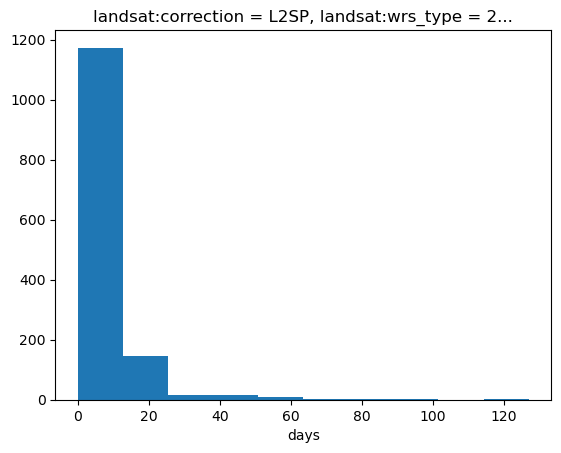

In [33]:
qa = stack.sel(band="qa_pixel").astype("uint16")
bad = qa & bitmask  # just look at those 4 bits

good = stack.where(bad == 0)  # mask pixels where any one of those bits are set

# Check the typical interval between scenes?
good.time.diff("time").dt.days.plot.hist();

In [34]:
good

<xarray.DataArray 'stackstac-f5d939d32a40dff483caac8d004d941f' (time: 1366,
                                                                band: 22,
                                                                y: 7557, x: 7679)>
dask.array<where, shape=(1366, 22, 7557, 7679), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/23)
  * time                         (time) datetime64[ns] 2002-02-28T18:40:49.42...
    id                           (time) <U31 'LE07_L2SP_045033_20020228_02_T1...
  * band                         (band) <U13 'qa' 'red' ... 'qa_aerosol'
  * x                            (x) float64 4.337e+05 4.337e+05 ... 6.64e+05
  * y                            (y) float64 4.299e+06 4.299e+06 ... 4.072e+06
    platform                     (time) <U9 'landsat-7' ... 'landsat-8'
    ...                           ...
    proj:epsg                    int64 32610
    landsat:wrs_path             (time) <U3 '045' '045' '043' ... '044' '044'
    created                      (time) <U27 '2022-05-06T18:05:22.133255Z' .....
    instruments                  (time) object ['etm+'] ... ['oli', 'tirs']
    view:off_nadir               int64 0
    epsg                         int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(433710.0, 4072020.0, 664080.0...
    crs:         epsg:32610
    transform:   | 30.00, 0.00, 433710.00|\n| 0.00,-30.00, 4298730.00|\n| 0.0...
    resolution:  30.0

In [35]:
rgb = good.sel(band = ['red','green','blue'])
rgb

<xarray.DataArray 'stackstac-f5d939d32a40dff483caac8d004d941f' (time: 1366,
                                                                band: 3,
                                                                y: 7557, x: 7679)>
dask.array<getitem, shape=(1366, 3, 7557, 7679), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/23)
  * time                         (time) datetime64[ns] 2002-02-28T18:40:49.42...
    id                           (time) <U31 'LE07_L2SP_045033_20020228_02_T1...
  * band                         (band) <U13 'red' 'green' 'blue'
  * x                            (x) float64 4.337e+05 4.337e+05 ... 6.64e+05
  * y                            (y) float64 4.299e+06 4.299e+06 ... 4.072e+06
    platform                     (time) <U9 'landsat-7' ... 'landsat-8'
    ...                           ...
    proj:epsg                    int64 32610
    landsat:wrs_path             (time) <U3 '045' '045' '043' ... '044' '044'
    created                      (time) <U27 '2022-05-06T18:05:22.133255Z' .....
    instruments                  (time) object ['etm+'] ... ['oli', 'tirs']
    view:off_nadir               int64 0
    epsg                         int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(433710.0, 4072020.0, 664080.0...
    crs:         epsg:32610
    transform:   | 30.00, 0.00, 433710.00|\n| 0.00,-30.00, 4298730.00|\n| 0.0...
    resolution:  30.0

In [36]:
nir = good.sel(band="nir08")
swir = good.sel(band="swir16")
nbr = (nir-swir)/((nir+swir)+.00001)
nbr

<xarray.DataArray 'stackstac-f5d939d32a40dff483caac8d004d941f' (time: 1366,
                                                                y: 7557, x: 7679)>
dask.array<truediv, shape=(1366, 7557, 7679), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/22)
  * time                         (time) datetime64[ns] 2002-02-28T18:40:49.42...
    id                           (time) <U31 'LE07_L2SP_045033_20020228_02_T1...
  * x                            (x) float64 4.337e+05 4.337e+05 ... 6.64e+05
  * y                            (y) float64 4.299e+06 4.299e+06 ... 4.072e+06
    platform                     (time) <U9 'landsat-7' ... 'landsat-8'
    view:sun_azimuth             (time) float64 146.6 145.6 ... 161.3 160.2
    ...                           ...
    proj:epsg                    int64 32610
    landsat:wrs_path             (time) <U3 '045' '045' '043' ... '044' '044'
    created                      (time) <U27 '2022-05-06T18:05:22.133255Z' .....
    instruments                  (time) object ['etm+'] ... ['oli', 'tirs']
    view:off_nadir               int64 0
    epsg                         int64 32610

In [ ]:
'''
# Example bounding box
trabing = (-121.83640772656835, 36.92954388901306, -121.80164629773535, 36.949507046771174)
#trabing_nbr = nbr.sel(lon=slice(trabing[0], trabing[2]), lat=slice(trabing[1], trabing[3]))


min_lon = -121.83640772656835
min_lat = 36.92954388901306
max_lon = -121.80164629773535
max_lat = 36.949507046771174

trabing_nbr = nbr.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)


#trabing_nbr = nbr.rio.clip_box(minx=trabing[0], miny=trabing[1], maxx=trabing[2], maxy=trabing[3])


#trabing_nbr = nbr(bbox = trabing)
'''

In [52]:
monthly = nbr.resample(time="MS").median("time", keep_attrs=True)

In [53]:
monthly

<xarray.DataArray 'stackstac-f5d939d32a40dff483caac8d004d941f' (time: 263,
                                                                y: 7557, x: 7679)>
dask.array<where, shape=(263, 7557, 7679), dtype=float64, chunksize=(4, 965, 965), chunktype=numpy.ndarray>
Coordinates:
  * x                          (x) float64 4.337e+05 4.337e+05 ... 6.64e+05
  * y                          (y) float64 4.299e+06 4.299e+06 ... 4.072e+06
  * time                       (time) datetime64[ns] 2002-02-01 ... 2023-12-01
    landsat:correction         <U4 'L2SP'
    landsat:wrs_type           <U1 '2'
    landsat:collection_number  <U2 '02'
    proj:epsg                  int64 32610
    view:off_nadir             int64 0
    epsg                       int64 32610

In [63]:
# ensure correct crs and view stac
monthly = monthly.rio.write_crs("32610", inplace=True)
monthly

<xarray.DataArray 'stackstac-f5d939d32a40dff483caac8d004d941f' (time: 263,
                                                                y: 7557, x: 7679)>
dask.array<where, shape=(263, 7557, 7679), dtype=float64, chunksize=(4, 965, 965), chunktype=numpy.ndarray>
Coordinates:
  * x                          (x) float64 4.337e+05 4.337e+05 ... 6.64e+05
  * y                          (y) float64 4.299e+06 4.299e+06 ... 4.072e+06
  * time                       (time) datetime64[ns] 2002-02-01 ... 2023-12-01
    landsat:correction         <U4 'L2SP'
    landsat:wrs_type           <U1 '2'
    landsat:collection_number  <U2 '02'
    proj:epsg                  int64 32610
    view:off_nadir             int64 0
    epsg                       int64 32610
    spatial_ref                int64 0

EPSG:32610
EPSG:32610
                                                                geometry  \
FIRE_NAME                                                                  
37                     MULTIPOLYGON Z (((547067.425 4221269.428 0.000...   
CZU LIGHTNING COMPLEX  MULTIPOLYGON Z (((575625.322 4101426.881 0.000...   
FREEDOM                MULTIPOLYGON Z (((603345.288 4092670.600 0.000...   
GLASS                  MULTIPOLYGON Z (((537944.646 4253767.360 0.000...   
HIGHWAY                POLYGON Z ((575260.346 4207866.444 0.000, 5752...   

                      YEAR_ STATE AGENCY UNIT_ID   INC_NUM  ALARM_DATE  \
FIRE_NAME                                                                
37                     2017    CA    CDF     LNU  00002957  2017-10-09   
CZU LIGHTNING COMPLEX  2020    CA    CDF     CZU  00005205  2020-08-16   
FREEDOM                2021    CA    CDF     CZU  00000489  2021-01-19   
GLASS                  2020    CA    CDF     LNU  00015497  2020-09-27   
H

<Axes: >

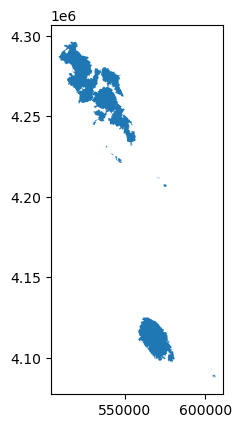

In [64]:
# Odd part of the workflow. We have to change polygons to 32610 to extract the geometry
# And then turn that geometry into a geojson, which returns crs to 4326

#Change EucAreas and FireAreas CRS to match monthly
Fire_Areas=FireAreas.to_crs(32610)
Euc_Areas=EucAreas.to_crs(32610)
print(Fire_Areas.crs)
print(Euc_Areas.crs)
print(Fire_Areas.head())
Fire_Areas.plot()


In [65]:

# In case you want to visualize polygons again
# Will not work with Fire_Areas because its in 32610
# Fancy bit of code right here

from shapely.geometry import mapping

# Assuming you already have your FireAreas GeoDataFrame
# Create a Leaflet Map
m1 = leafmap.Map(center=[37.82, -122.39], zoom=9, height="800px")

# Iterate over the rows of the GeoDataFrame
for index, row in Fire_Areas.iterrows():
    # Convert the geometry to a GeoJSON-like dictionary
    feature_geometry = mapping(row.geometry)
    
    # Add the GeoJSON-like dictionary to the map
    m1.add_geojson(feature_geometry, layer_name=f"Fire {index}")

# Display the map
m1


string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'


Map(center=[37.82, -122.39], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [ ]:
'''
#Double check everything is still properly projected and matches up
fire_example = Fire_Areas.iloc[2].geometry
euc_example = Euc_Areas.iloc[2].geometry

# Create GeoDataFrames with a single row for visualization
gdf_fire_example = gpd.GeoDataFrame(geometry=[fire_example])
gdf_euc_example = gpd.GeoDataFrame(geometry=[euc_example])

# Plot the fire area
ax = gdf_fire_example.plot(color='red', alpha=0.5, label='Fire Area')

# Plot the Eucalyptus areas on the same plot
gdf_euc_example.plot(ax=ax, color='green', alpha=0.5, label='Eucalyptus Area')

# Add legend
ax.legend()

# Show the plot
plt.show()
'''

In [79]:
# turn the geometry of Fire_Areas and Euc_Areas item into geojson, which can be cropped/clipped to
clip_geometry_fire = [geojson.loads(Fire_Areas.to_json())['features'][2]['geometry']]
clip_geometry_euc = [geojson.loads(Euc_Areas.to_json())['features'][2]['geometry']]
print(type(clip_geometry_fire))
print(type(clip_geometry_euc))

<class 'list'>
<class 'list'>


In [ ]:
Euc_Areas

In [70]:
Fire_Areas

,geometry,YEAR_,STATE,AGENCY,UNIT_ID,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,COMPLEX_NA,COMPLEX_IN,IRWINID,Shape_Leng,Shape_Area
FIRE_NAME,,,,,,,,,,,,,,,,,,,
37,MULTIPOLYGON Z (((547067.425 4221269.428 0.000...,2017,CA,CDF,LNU,00002957,2017-10-09,2017-10-16,11,LFB8. DIGITIZED FROM DIGITALGLOBE (MAXAR) IMA...,1613.2200,4,1,None,None,None,F570C977-2D96-4BB0-A146-52D1A32FA87D,46336.050945,1.057459e+07
CZU LIGHTNING COMPLEX,MULTIPOLYGON Z (((575625.322 4101426.881 0.000...,2020,CA,CDF,CZU,00005205,2020-08-16,2020-09-24,1,None,86553.5000,7,1,None,CZU LIGHTNING COMPLEX,00005205,None,255052.193260,5.523185e+08
FREEDOM,MULTIPOLYGON Z (((603345.288 4092670.600 0.000...,2021,CA,CDF,CZU,00000489,2021-01-19,2021-01-22,11,None,33.2592,1,1,None,None,None,None,4130.554410,2.112959e+05
GLASS,MULTIPOLYGON Z (((537944.646 4253767.360 0.000...,2020,CA,CDF,LNU,00015497,2020-09-27,2020-10-20,14,J. Baldwin,67484.4000,7,1,None,None,None,None,272074.173454,4.470432e+08
HIGHWAY,"POLYGON Z ((575260.346 4207866.444 0.000, 5752...",2004,CA,CDF,SCU,00003485,2004-06-25,2004-06-28,2,None,624.9360,1,1,00000181,None,None,None,10317.778914,4.080267e+06
KINCADE,MULTIPOLYGON Z (((516197.961 4268642.266 0.000...,2019,CA,CDF,LNU,00019376,2019-10-23,2019-11-10,11,None,77762.1000,1,1,None,None,None,None,238568.856409,5.171126e+08
LAKEVILLE,MULTIPOLYGON Z (((541453.184 4226975.456 0.000...,2020,CA,CDF,LNU,00008347,2020-06-05,2020-06-05,2,Brandon Bertolino,159.6800,6,1,None,None,None,None,4456.877916,1.048804e+06
NUNS,MULTIPOLYGON Z (((536491.339 4257947.967 0.000...,2017,CA,CDF,LNU,00010049,2017-10-08,2017-10-31,14,"Nuns,Partrick, Adobe, Norrbom and Pressley mer...",55798.2000,3,1,None,SOUTHERN LNU COMPLEX,00010105,None,305483.095957,3.680012e+08
PRESSLEY,"POLYGON Z ((532414.443 4247745.951 0.000, 5324...",2017,CA,CDF,LNU,00010049,2017-10-08,2017-10-15,14,Merged into Nuns,791.8880,7,1,None,SOUTHERN LNU COMPLEX,00010105,None,22361.236288,5.220480e+06


In [ ]:
#It's a long list of coordinates. Defaults to 4326 when it becomes geojson
clip_geometry_fire

In [80]:
fire_clip = monthly.rio.clip(cropping_geometry_fire)
euc_clip = monthly.rio.clip(cropping_geometry_euc)

In [ ]:
crop = monthly.rio.clip(geometries=json.loads(json.dumps(shapely.geometry.mapping(Fire_Areas.iloc[4].geometry))), crs=32610)

In [ ]:
crop

In [92]:
timeClip_euc = euc_clip.sel(time=slice("2020-11-01", "2023-02-01"))
timeClip_fire = fire_clip.sel(time=slice("2020-11-01", "2023-02-01"))

In [ ]:
#type(geojson.loads(FireList1.to_json())['features'][0]['geometry'])

In [ ]:
#type(FireList1.iloc[[0]].geometry.to_json()

In [ ]:
freedom_ts = timeCrop.persist()

In [ ]:
geometry.crs
monthly.crs

In [93]:
EucCleaned = timeClip_euc.ffill("time")[1:]
FireCleaned = timeClip_fire.ffill("time")[1:]

In [94]:
FireMean = FireCleaned.mean(dim=['x','y'], skipna=True, keep_attrs=True)
EucMean = EucCleaned.mean(dim=['x','y'], skipna=True, keep_attrs=True)
FireMean

<xarray.DataArray 'stackstac-f5d939d32a40dff483caac8d004d941f' (time: 27)>
dask.array<mean_agg-aggregate, shape=(27,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time                       (time) datetime64[ns] 2020-12-01 ... 2023-02-01
    landsat:correction         <U4 'L2SP'
    landsat:wrs_type           <U1 '2'
    landsat:collection_number  <U2 '02'
    proj:epsg                  int64 32610
    view:off_nadir             int64 0
    epsg                       int64 32610
    spatial_ref                int64 0

In [ ]:
ts = cleaned.persist()

In [ ]:
rgbgif = dgif(cleaned, fps=2).compute()

In [ ]:
rgbgif

In [ ]:
ts_local = freedom_ts.compute()
ts_local.plot.imshow(col="time", col_wrap=3, robust=True)
#ts_local.plot.imshow(col="time", rgb="band", col_wrap=3, robust=True)

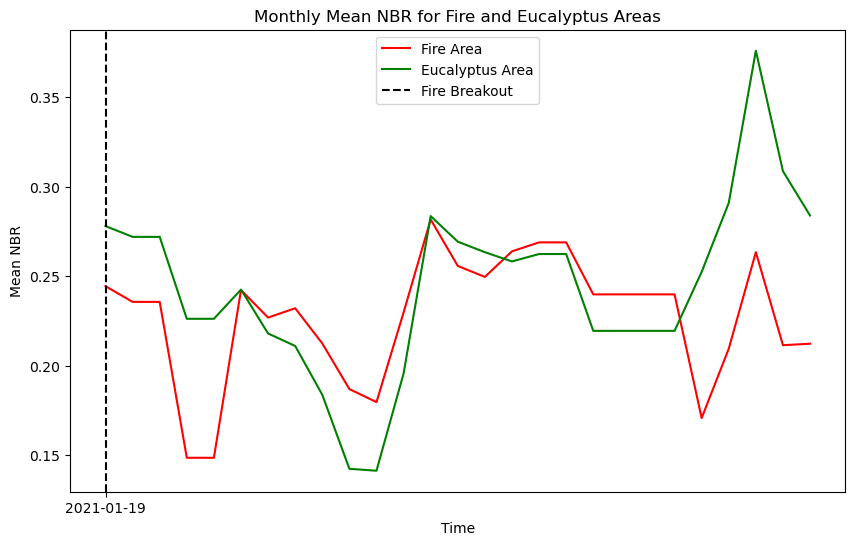

In [105]:
# Plot euc NBR vs rest of fire NBR for one fire area
# Specify the time point when the fire broke out
fire_breakout_time = '2021-01-19'  # Replace with the actual time

# Plotting
plt.figure(figsize=(10, 6))

# Plot mean NBR for the first area (Fire)
plt.plot(FireMean, label='Fire Area', color='red')

# Plot mean NBR for the second area (Euc)
plt.plot(EucMean, label='Eucalyptus Area', color='green')

# Add a vertical line indicating the time point when the fire broke out
plt.axvline(x=fire_breakout_time, color='black', linestyle='--', label='Fire Breakout')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Mean NBR')
plt.title('Monthly Mean NBR for Fire and Eucalyptus Areas')
plt.legend()

# Increase the number of tick labels on the x-axis
#plt.xticks(rotation=45)  # Rotate the labels for better visibility
#plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set tick locations to months
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format tick labels as 'YYYY-MM'

# Show the plot
plt.show()


/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice e

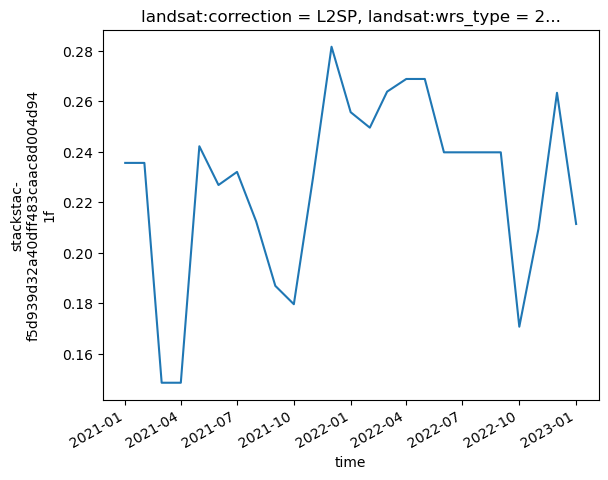

In [84]:
p=FireMean.plot()
p

In [ ]:
#This will break don't run it
gif_img = geogif.dgif(cleaned).compute()

In [ ]:
dask.utils.format_bytes(len(gif_img.data))

In [ ]:
gif_img

In [ ]:
FireList_sorted.head(13).bounds

In [ ]:
FireList_sorted.head()

In [ ]:
FireList_sorted.head(1).plot()